In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [5]:
tf.reset_default_graph()

In [6]:
#Loading the MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
np.random.seed(42)
tf.set_random_seed(42)

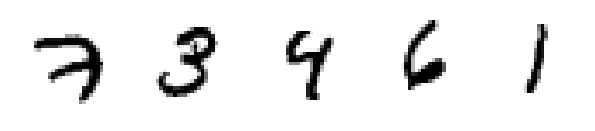

In [10]:
#Visualizing the dataset
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [11]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

In [13]:
#Input Layer for the images
X = tf.placeholder(shape=[None,28,28,1], dtype = tf.float32, name= "X")
#None for batch_size

In [17]:
#Primary Capsule Layer
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps*6*6 #1152 primary capsule units
caps1_n_dims = 8


In [18]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [19]:
conv1 = tf.layers.conv2d(X, name = 'conv1', **conv1_params)
conv2 = tf.layers.conv2d(conv1, name = "conv2", **conv2_params)


In [20]:
# Shape of Output of conv2: (batch_size, 6, 6, 32, 8) 
# Since this first capsule layer will be fully connected to the next capsule layer, we can simply flatten the 6×6 grids
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims], name = 'caps1_raw')


In [26]:
def squash(s, epsilon = 1e-7, name=None):
    with tf.name_scope(name, default_name = 'squash'):
        squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keep_dims=True)
        safe_norm = tf.sqrt(squared_norm+epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor*unit_vector

In [27]:
caps1_output = squash(caps1_raw, name="caps1_output")

In [ ]:
#Digit Caps
caps2_n_cap = 10
caps2_n_dims = 16